# Stock Portfolio Optimizer

This project builds an optimized stock portfolio by combining financial data analysis with machine learning techniques.  

I have selected major stocks across sectors, reduced dimensions with t-SNE, grouped similar stocks using K-Means clustering, and applied constrained optimization to maximize Sharpe and Sortino ratios while maintaining diversification.

# <img src="../Images/project_image.png" alt="" width="300">

## Table of Contents
1. [Setup and Imports](#setup)
2. [Data Collection](#data)
3. [Data Preprocessing](#preprocessing)
4. [Risk & Return Calculations](#calculations)
5. [Portfolio Optimization](#optimization)
6. [Monte Carlo Simulation](#simulation)
7. [Results Analysis](#results)

<a id="setup"></a>
## 1. Setup and Imports

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Set plotting style
sns.set_style('whitegrid')

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Set random seed
np.random.seed(42) 

#Suppress warnings
import warnings
warnings.filterwarnings('ignore')

<a id='data'></a>
## 2. Data Collection and Preprocessing

Selected major stocks across sectors and fetched historical closing prices using yfinance.

In [ ]:
# Define stock tickers by sector (taken big companies at random for demostration)
tickers = {
    'Technology': ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'AMD', 'INTC', 'QCOM', 'IBM'],
    'Energy': ['XOM', 'CVX', 'COP', 'SLB', 'BP'],
    'Financials': ['JPM', 'BAC', 'WFC', 'C', 'GS'],
    'Healthcare': ['JNJ', 'PFE', 'MRK', 'ABBV', 'TMO'],
    'Consumer': ['TSLA', 'HD', 'NKE', 'SBUX', 'MCD']
} # This is a mock portfolio for the project. It blends sector leaders across Technology, Energy, Financials, Healthcare, and Consumer to create a diversified base for optimization.


# Flatten tickers list
all_tickers = [ticker for sector in tickers.values() for ticker in sector]

# Set date range
start_date = '2014-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

# Fetch historical data
def get_stock_data(tickers, start, end):
    """Fetch historical stock data for given tickers."""
    data = yf.download(tickers, start=start, end=end)
    if isinstance(data.columns, pd.MultiIndex):
        data = data['Close']
    else:
        data = data[['Close']]
    return data

# Get stock data
stock_data = get_stock_data(all_tickers, start_date, end_date)
print('Data shape:', stock_data.shape)
stock_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  30 of 30 completed


Data shape: (2845, 30)


Ticker,AAPL,ABBV,AMD,AMZN,BAC,BP,C,COP,CVX,GOOGL,GS,HD,IBM,INTC,JNJ,JPM,MCD,META,MRK,MSFT,NKE,NVDA,PFE,QCOM,SBUX,SLB,TMO,TSLA,WFC,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-02,17.2154,32.6783,3.95,19.8985,12.8956,24.9743,39.7036,48.3176,77.3605,27.7233,142.5944,63.1679,111.7598,19.1788,66.6776,42.7993,71.8542,54.4534,33.4898,30.9964,34.2775,0.3739,18.5162,53.3930,31.1288,65.7161,105.8099,10.0067,32.6956,62.1832
2014-01-03,16.8372,32.8795,4.00,19.8220,13.1439,24.9171,40.5619,48.4422,77.4914,27.5211,143.6101,63.0678,112.4284,19.1714,67.2783,43.1302,71.9510,54.3041,33.6522,30.7879,34.1855,0.3695,18.5526,53.0799,31.0401,65.3683,106.2153,9.9707,32.9280,62.0336
2014-01-06,16.9290,31.6787,4.13,19.6815,13.3441,24.9847,40.8733,48.6499,77.2857,27.8279,144.5936,62.4594,112.0429,18.9334,67.6299,43.3802,71.4368,56.9317,33.6590,30.1373,33.9227,0.3744,18.5709,52.9416,30.7254,65.1242,106.2249,9.8000,32.9861,62.1271
2014-01-07,16.8080,31.7416,4.18,19.9015,13.2160,25.2710,41.1544,48.7261,77.9401,28.3644,143.7230,62.7675,114.2777,19.0301,69.0655,42.8802,71.8318,57.6483,33.9094,30.3708,33.9490,0.3805,18.6864,53.3348,31.1450,64.7468,108.3966,9.9573,32.9716,63.0061
2014-01-08,16.9144,31.6599,4.18,20.0960,13.2800,25.3647,41.6329,48.2552,76.8308,28.4234,143.8439,63.0986,113.2296,18.9111,68.9703,43.2846,71.1089,57.9568,33.6928,29.8286,33.7737,0.3857,18.8140,53.6552,31.4757,64.3547,110.0663,10.0853,33.3492,62.8004


<a id='preprocessing'></a>
## 3. Risk & Return Calculations

Calculate daily returns, annualized returns, and annualized volitility.

In [3]:
# Calculate daily returns
daily_returns = stock_data.pct_change().dropna()

# Calculate annualized metrics
annual_expected_returns = daily_returns.mean() * 252
volatility = daily_returns.std() * np.sqrt(252)

print('Expected Annual Returns:\n', annual_expected_returns.round(4))
print('\nAnnualized Volatility:\n', volatility.round(4))

Expected Annual Returns:
 Ticker
AAPL     0.2620
ABBV     0.1870
AMD      0.4438
AMZN     0.2528
BAC      0.1462
BP       0.0608
C        0.1001
COP      0.1270
CVX      0.0940
GOOGL    0.1947
GS       0.1596
HD       0.1829
IBM      0.0922
INTC     0.0772
JNJ      0.0909
JPM      0.1906
MCD      0.1512
META     0.2738
MRK      0.1007
MSFT     0.2595
NKE      0.0919
NVDA     0.6149
PFE      0.0441
QCOM     0.1546
SBUX     0.1264
SLB      0.0184
TMO      0.1539
TSLA     0.4520
WFC      0.1134
XOM      0.0861
dtype: float64

Annualized Volatility:
 Ticker
AAPL     0.2862
ABBV     0.2655
AMD      0.5760
AMZN     0.3304
BAC      0.3060
BP       0.3078
C        0.3226
COP      0.3739
CVX      0.2889
GOOGL    0.2822
GS       0.2855
HD       0.2387
IBM      0.2386
INTC     0.3648
JNJ      0.1798
JPM      0.2689
MCD      0.1994
META     0.3766
MRK      0.2174
MSFT     0.2670
NKE      0.2978
NVDA     0.4792
PFE      0.2273
QCOM     0.3604
SBUX     0.2786
SLB      0.3841
TMO      0.2461
TSLA    

<a id='clustering'></a>
## 4. Stock Clustering Analysis

Applied t-SNE for dimensionality reduction and K-Means clustering to group stocks with similar long-term price movement patterns.

In [4]:
# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=1, n_iter=1000)
tsne_embeddings = tsne.fit_transform(daily_returns.T)

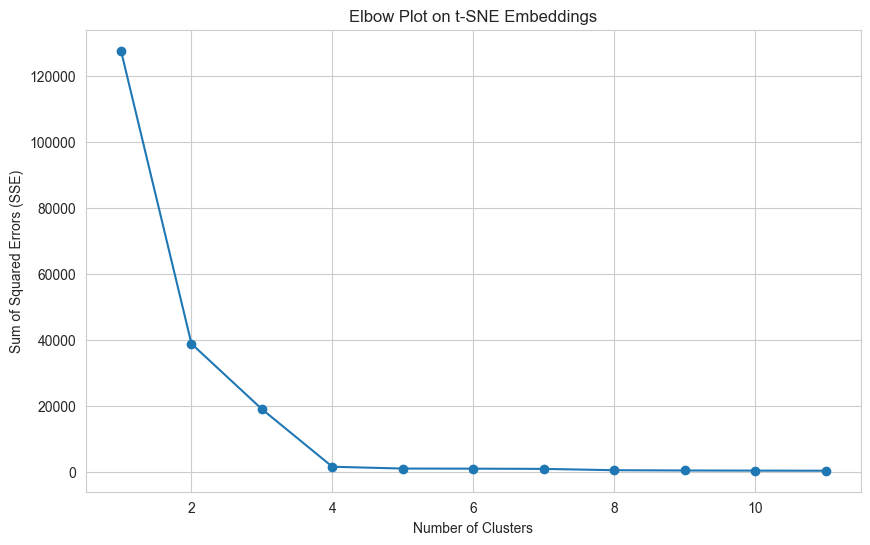

In [5]:
# Determine optimal number of clusters using elbow method
sse = []
k_range = range(1, 12)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tsne_embeddings)
    sse.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Plot on t-SNE Embeddings')
plt.grid(True)
plt.show()

**Elbow Plot Interpretation:**
The elbow at k = 4 indicates an optimal number of clusters, balancing complexity and explanatory power when grouping stocks by similar long-term return behavior.

In [6]:
# Perform clustering with chosen number of clusters (based on elbow plot)
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(tsne_embeddings)

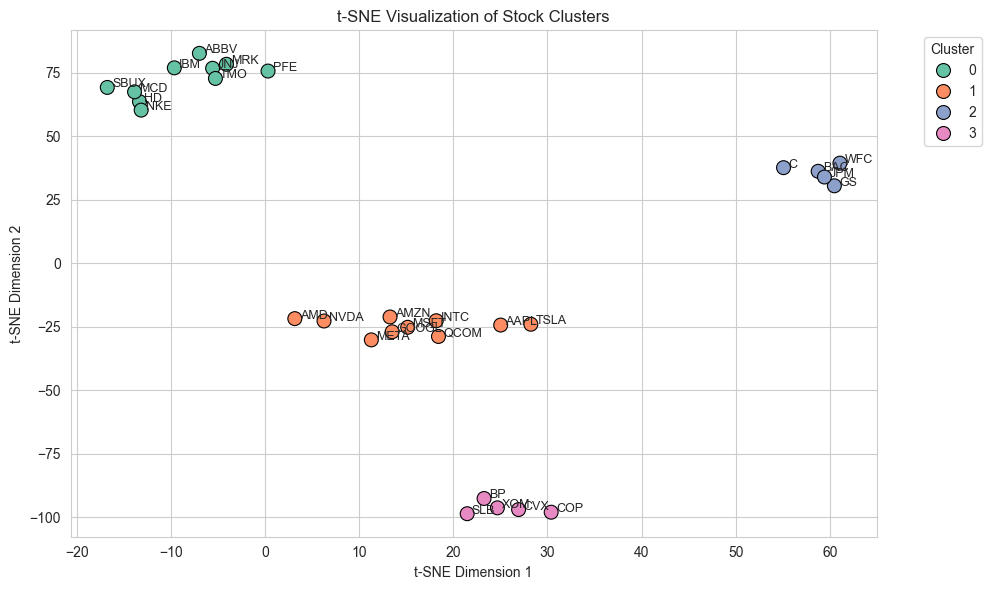

In [7]:
# Create DataFrame with t-SNE results and cluster labels
tsne_df = pd.DataFrame(tsne_embeddings, columns=['tSNE1', 'tSNE2'])
tsne_df['Ticker'] = daily_returns.columns
tsne_df['Cluster'] = cluster_labels

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=tsne_df,
    x='tSNE1', y='tSNE2',
    hue='Cluster',
    palette='Set2',
    s=100,
    edgecolor='black'
)

# Add ticker labels
for _, row in tsne_df.iterrows():
    plt.text(row['tSNE1'] + 0.5, row['tSNE2'], row['Ticker'], fontsize=9)

plt.title('t-SNE Visualization of Stock Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**t-SNE Stock Clusters:**
The t-SNE projection reveals four distinct stock clusters, highlighting groups of companies with similar long-term return behaviors—often aligning with sectoral patterns like Energy, Tech, and Financials.

<a id='optimization'></a>
## 5. Portfolio Optimization

Used SLSQP optimization to maximize Sharpe and Sortino ratios, subject to constraints that promote diversification and practical portfolio construction.

**Sharpe Ratio:**  
Measures risk-adjusted return by comparing excess returns to overall portfolio volatility.

**Sortino Ratio:**  
Similar to Sharpe but only penalizes downside volatility, focusing on harmful risk instead of total fluctuations.

**Constraints Applied:**
- **Sum-to-one constraint**: Ensures the portfolio is fully invested.
- **Cluster weight cap**: Limits any single cluster (group of similar stocks) to a maximum of 50% to reduce concentration risk.
- **Minimum allocation threshold**: Enforces that non-zero weights are at least 1%, avoiding tiny, inefficient positions.
- **Weight bounds (0–25%)**: Restricts exposure to any single stock for better balance across holdings.



In [14]:
def portfolio_perf(weights, daily_returns, risk_free_rate=0.02):
    """ Calculate portfolio performance metrics including Sortino ratio.
    
    Parameters:
    - weights: 1D array-like, portfolio weights (sum to 1)
    - daily_returns: 2D array-like, shape (n_days, n_assets) of daily returns
    - risk_free_rate: annual risk-free rate, e.g., 0.02 for 2%
    
    Returns:
    - portfolio_return: annualized portfolio return 
    - portfolio_volatility: annualized volatility 
    - sharpe_ratio: annualized Sharpe ratio 
    - sortino_ratio: annualized Sortino ratio """
    
    # Sharpe Ratio
    avg_daily_returns = np.mean(daily_returns, axis=0)
    annualized_returns = avg_daily_returns * 252
    cov_matrix = np.cov(daily_returns, rowvar=False)
    portfolio_return = np.dot(annualized_returns, weights)
    annualized_cov_matrix = cov_matrix * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(annualized_cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    # Sortino Ratio
    daily_portfolio_returns = np.dot(daily_returns, weights)
    daily_rf = risk_free_rate / 252
    excess_returns = daily_portfolio_returns - daily_rf
    negative_excess = np.where(excess_returns < 0, excess_returns, 0.0)
    downside_deviation_daily = np.sqrt(np.mean(negative_excess ** 2))
    annual_downside_deviation = downside_deviation_daily * np.sqrt(252)
    sortino_ratio = (portfolio_return - risk_free_rate) / annual_downside_deviation if annual_downside_deviation > 0 else np.nan
    
    return portfolio_return, portfolio_volatility, sharpe_ratio, sortino_ratio

def neg_sharpe(weights, daily_returns, risk_free_rate=0.02):
    """Negative Sharpe ratio for minimization."""
    return -portfolio_perf(weights, daily_returns, risk_free_rate)[2]

def neg_sortino(weights, daily_returns, risk_free_rate=0.02):
    """Negative Sortino ratio for minimization."""
    return -portfolio_perf(weights, daily_returns, risk_free_rate)[3]

def cluster_constraint(weights, cluster_labels, max_cluster_weight=0.5):
    """Ensure no cluster exceeds maximum weight."""
    penalty = 0
    for cluster in np.unique(cluster_labels):
        cluster_mask = cluster_labels == cluster
        cluster_weight = np.sum(weights[cluster_mask])
        if cluster_weight > max_cluster_weight:
            penalty += cluster_weight - max_cluster_weight
    return penalty

def min_allocation_constraint(weights, min_allocation=0.01):
    """
    Ensure weights are either 0 or at least min_allocation.
    Returns a penalty value if constraint is violated.
    """
    invalid_weights = np.where((weights > 1e-6) & (weights < min_allocation))[0]
    if len(invalid_weights) > 0:
        return np.sum(min_allocation - weights[invalid_weights])
    return 0

# Optimization constraints
constraints = [
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
    {'type': 'ineq', 'fun': lambda weights: -cluster_constraint(weights, cluster_labels)},
    {'type': 'ineq', 'fun': lambda weights: -min_allocation_constraint(weights, min_allocation=0.01)}
]

# Bounds for weights (0 to 25% per stock)
bounds = [(0, 0.25) for _ in range(len(stock_data.columns))]

# Initial guess (equal weights)
initial_weights = np.array([1.0 / len(stock_data.columns)] * len(stock_data.columns))

# Run optimization
sharpe_result = minimize(
    neg_sharpe,
    initial_weights,
    args=(daily_returns,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

sortino_result = minimize(
    neg_sortino,
    initial_weights,
    args=(daily_returns,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Get optimal weights
sharpe_optimal_weights = sharpe_result.x
sortino_optimal_weights = sortino_result.x

# Clean up very small weights to be exactly zero
sharpe_optimal_weights[sharpe_optimal_weights < 1e-4] = 0
sortino_optimal_weights[sortino_optimal_weights < 1e-4] = 0

# Re-normalize weights to ensure they sum to 1
sharpe_optimal_weights /= np.sum(sharpe_optimal_weights)
sortino_optimal_weights /= np.sum(sortino_optimal_weights)

# Create DataFrames
sharpe_optimal_portfolio = pd.DataFrame({
    'Ticker': stock_data.columns,
    'Weight': sharpe_optimal_weights,
    'Cluster': cluster_labels
})
sharpe_optimal_portfolio = sharpe_optimal_portfolio[sharpe_optimal_portfolio['Weight'] > 0]


sortino_optimal_portfolio = pd.DataFrame({
    'Ticker': stock_data.columns,
    'Weight': sortino_optimal_weights,
    'Cluster': cluster_labels
})
sortino_optimal_portfolio = sortino_optimal_portfolio[sortino_optimal_portfolio['Weight'] > 0]

# Calculate cluster weights
sharpe_cluster_weights = sharpe_optimal_portfolio.groupby('Cluster')['Weight'].sum()
sortino_cluster_weights = sortino_optimal_portfolio.groupby('Cluster')['Weight'].sum()

# Calculate portfolio performance metrics
sharpe_portfolio_return, sharpe_portfolio_volatility, sharpe_sharpe_ratio, sharpe_sortino_ratio = portfolio_perf(sharpe_optimal_weights, daily_returns)
sortino_portfolio_return, sortino_portfolio_volatility, sortino_sharpe_ratio, sortino_sortino_ratio = portfolio_perf(sortino_optimal_weights, daily_returns)

# Display sharpe optimal portfolio weights and performance metrics in a table
print('\nSharpe Ratio Optimal Portfolio Weights and Performance Metrics:')
print(sharpe_optimal_portfolio.sort_values('Weight', ascending=False).head())
print(f'\nPortfolio Return: {sharpe_portfolio_return:.2%}')
print(f'Portfolio Volatility: {sharpe_portfolio_volatility:.2%}')  
print(f'Sharpe Ratio: {sharpe_sharpe_ratio:.2f}')
print(f'Sortino Ratio: {sharpe_sortino_ratio:.2f}')
print(f'Number of Stocks in Portfolio: {len(sharpe_optimal_portfolio)}')

print('\nCluster Weights:')
print(sharpe_cluster_weights)

# Display sortino optimal portfolio weights and performance metrics in a table
print('\nSortino Ratio Optimal Portfolio Weights and Performance Metrics:')
print(sortino_optimal_portfolio.sort_values('Weight', ascending=False).head())
print(f'\nPortfolio Return: {sortino_portfolio_return:.2%}')
print(f'Portfolio Volatility: {sortino_portfolio_volatility:.2%}')
print(f'Sharpe Ratio: {sortino_sharpe_ratio:.2f}')
print(f'Sortino Ratio: {sortino_sortino_ratio:.2f}')
print(f'Number of Stocks in Portfolio: {len(sortino_optimal_portfolio)}')

print('\nCluster Weights:')
print(sortino_cluster_weights)



Sharpe Ratio Optimal Portfolio Weights and Performance Metrics:
   Ticker  Weight  Cluster
21   NVDA  0.2500        1
16    MCD  0.2500        0
1    ABBV  0.2285        0
27   TSLA  0.0826        1
0    AAPL  0.0810        1

Portfolio Return: 31.82%
Portfolio Volatility: 22.69%
Sharpe Ratio: 1.31
Sortino Ratio: 1.91
Number of Stocks in Portfolio: 9

Cluster Weights:
Cluster
0    0.5000
1    0.4749
2    0.0251
Name: Weight, dtype: float64

Sortino Ratio Optimal Portfolio Weights and Performance Metrics:
   Ticker  Weight  Cluster
21   NVDA  0.2500        1
16    MCD  0.2500        0
1    ABBV  0.1956        0
0    AAPL  0.0822        1
27   TSLA  0.0781        1

Portfolio Return: 31.56%
Portfolio Volatility: 22.51%
Sharpe Ratio: 1.31
Sortino Ratio: 1.92
Number of Stocks in Portfolio: 9

Cluster Weights:
Cluster
0    0.5000
1    0.4877
2    0.0123
Name: Weight, dtype: float64


In [15]:
# Filter expected returns DataFrame for assets in either of the optimal portfolios
optimal_portfolio_assets = pd.concat([sharpe_optimal_portfolio, sortino_optimal_portfolio]).drop_duplicates(subset=['Ticker']).reset_index(drop=True)
filtered_stock_data = stock_data[optimal_portfolio_assets['Ticker'].values]

# Calculate daily returns for filtered assets
filtered_daily_returns = filtered_stock_data.pct_change().dropna()
filtered_returns = filtered_daily_returns.mean() 
filtered_cov = filtered_daily_returns.cov() 

<a id='simulation'></a>
## 6. Monte Carlo Simulation

Generated 10,000 random portfolios by assigning random weights to filtered assets and calculating their returns, volatility, Sharpe, and Sortino ratios.

Plotted the efficient frontier to visualize the risk-return landscape, highlighting portfolios with:
- Minimum volatility
- Maximum Sharpe ratio (among random portfolios)
- Maximum return

Also compared these with the Sharpe and Sortino ratio-optimized portfolios from the earlier constrained optimization.

**Key Outputs:**
- Efficient frontier scatter plot colored by Sharpe ratio
- Highlighted optimized portfolios for clear comparison
- Bar chart comparing asset weights across different portfolio strategies


In [28]:
# Monte Carlo Simulation with Cluster and Allocation Constraints
num_portfolios = 10000
results = np.zeros((4, num_portfolios)) 
weights_record = [] 
valid_portfolios = 0
filtered_cluster_labels = cluster_labels[np.isin(stock_data.columns, filtered_stock_data.columns)]

while valid_portfolios < num_portfolios:
    # Generate random weights
    weights = np.random.random(len(filtered_stock_data.columns))
    weights /= np.sum(weights)
    
    # Check bounds
    if np.any(weights > 0.25):
        continue
    # Check constraints
    if cluster_constraint(weights, filtered_cluster_labels) > 0:
        continue  # Skip if cluster weight exceeds limit
    if min_allocation_constraint(weights) > 0:
        continue  # Skip if any non-zero weight is below min threshold
    
    # Portfolio performance
    port_return, port_vol, sharpe_ratio, sortino_ratio = portfolio_perf(weights, filtered_daily_returns.values, risk_free_rate=0.02)
    
    # Store results
    results[:, valid_portfolios] = [port_vol, port_return, sharpe_ratio, sortino_ratio]
    weights_record.append(weights)
    valid_portfolios += 1

# Convert to arrays/DataFrames
weights_record = np.array(weights_record)

results_df = pd.DataFrame({
    'Volatility': results[0, :],
    'Return': results[1, :],
    'Sharpe': results[2, :],
    'Sortino': results[3, :]
})

# Output summary
print("Random Simulated Portfolios (with constraints) Statistics:")
print(results_df.describe())


Random Simulated Portfolios (with constraints) Statistics:
       Volatility      Return      Sharpe     Sortino
count  10000.0000  10000.0000  10000.0000  10000.0000
mean       0.2139      0.2688      1.1626      1.6772
std        0.0132      0.0205      0.0527      0.0797
min        0.1761      0.2007      0.9985      1.4482
25%        0.2045      0.2545      1.1205      1.6126
50%        0.2137      0.2688      1.1611      1.6729
75%        0.2229      0.2833      1.2045      1.7397
max        0.2613      0.3341      1.2990      1.8894


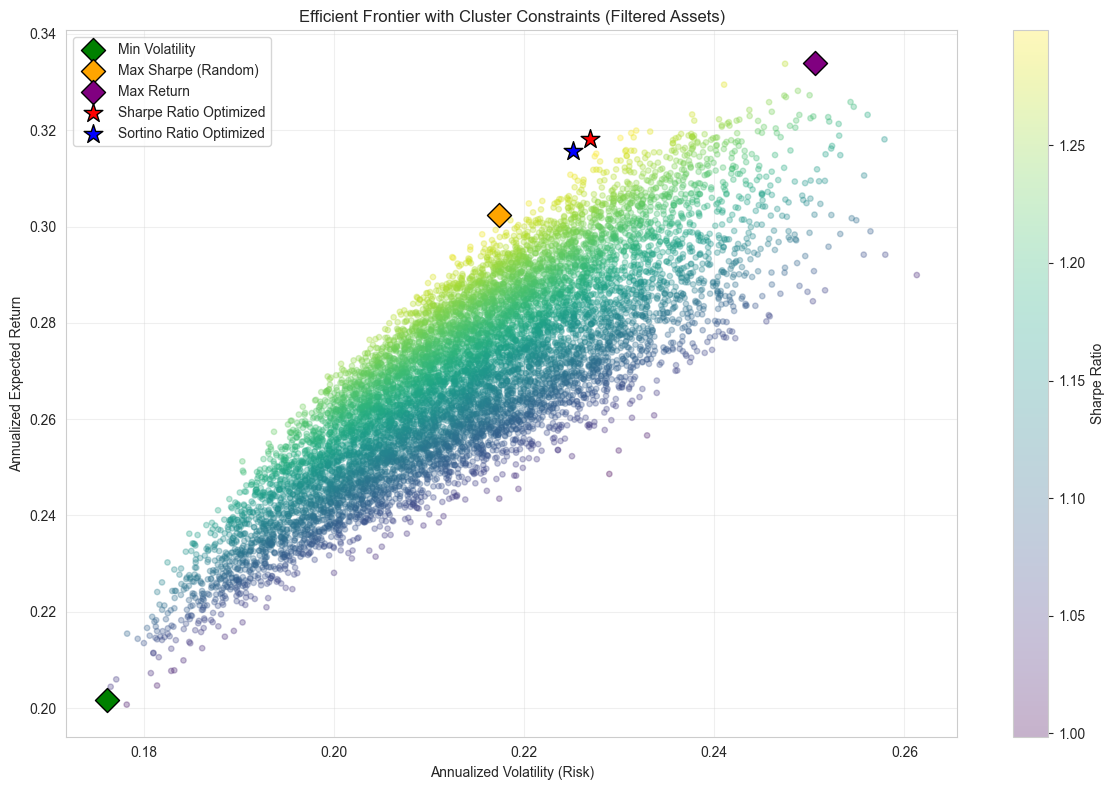


Optimized Portfolio Performance:
Sharpe Ratio Optimized: Return = 0.3182, Volatility = 0.2269, Sharpe = 1.3143
Sortino Ratio Optimized: Return = 0.3156, Volatility = 0.2251, Sharpe = 1.3131


In [29]:
# Plot efficient frontier
plt.figure(figsize=(12, 8))

# Plot ALL portfolios as scatter points
plt.scatter(results_df['Volatility'], results_df['Return'], 
           c=results_df['Sharpe'], cmap='viridis', alpha=0.3, s=15)
plt.colorbar(label='Sharpe Ratio')

# Calculate min vol, max sharpe, and max return portfolios
min_vol_idx = results_df['Volatility'].idxmin()
max_sharpe_idx = results_df['Sharpe'].idxmax()
max_return_idx = results_df['Return'].idxmax()

# Plot special portfolios from Monte Carlo simulation
plt.scatter(results_df.loc[min_vol_idx, 'Volatility'], 
            results_df.loc[min_vol_idx, 'Return'], 
            c='green', marker='D', s=150, label='Min Volatility', edgecolors='black')
            
plt.scatter(results_df.loc[max_sharpe_idx, 'Volatility'], 
            results_df.loc[max_sharpe_idx, 'Return'], 
            c='orange', marker='D', s=150, label='Max Sharpe (Random)', edgecolors='black')

plt.scatter(results_df.loc[max_return_idx, 'Volatility'], 
            results_df.loc[max_return_idx, 'Return'], 
            c='purple', marker='D', s=150, label='Max Return', edgecolors='black')

# Plot optimized portfolios
plt.scatter(sharpe_portfolio_volatility, sharpe_portfolio_return, c='red', marker='*', s=200, 
           label='Sharpe Ratio Optimized', edgecolors='black')

plt.scatter(sortino_portfolio_volatility, sortino_portfolio_return, c='blue', marker='*', s=200, 
           label='Sortino Ratio Optimized', edgecolors='black')

# Add labels and formatting
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Expected Return')
plt.title('Efficient Frontier with Cluster Constraints (Filtered Assets)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Force the plot to show all points
plt.tight_layout()
plt.show()

# Print performance metrics for optimized portfolios
print("\nOptimized Portfolio Performance:")
print(f"Sharpe Ratio Optimized: Return = {sharpe_portfolio_return:.4f}, Volatility = {sharpe_portfolio_volatility:.4f}, Sharpe = {sharpe_sharpe_ratio:.4f}")
print(f"Sortino Ratio Optimized: Return = {sortino_portfolio_return:.4f}, Volatility = {sortino_portfolio_volatility:.4f}, Sharpe = {sortino_sharpe_ratio:.4f}")


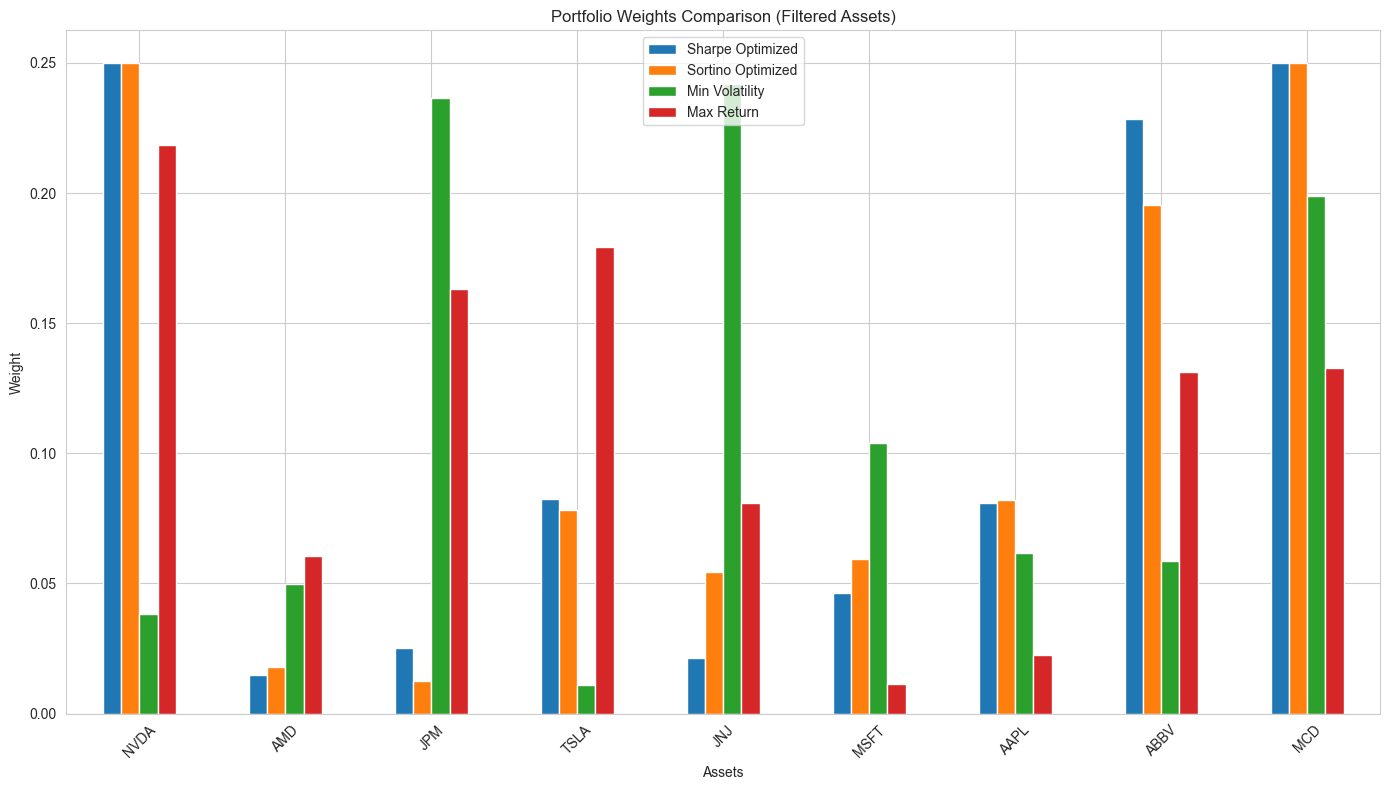

In [30]:
# Extract tickers from filtered stock data
filtered_tickers = filtered_stock_data.columns.tolist()

# Get the tickers from the optimal portfolios
sharpe_tickers = sharpe_optimal_portfolio['Ticker'].tolist()
sortino_tickers = sortino_optimal_portfolio['Ticker'].tolist()

# Extract the optimal weights for each portfolio
sharpe_opt_weights = pd.Series(sharpe_optimal_portfolio['Weight'].values, index=sharpe_optimal_portfolio['Ticker'])
sortino_opt_weights = pd.Series(sortino_optimal_portfolio['Weight'].values, index=sortino_optimal_portfolio['Ticker'])

# Get the weights from the Monte Carlo simulation
min_vol_weights = pd.Series(weights_record[min_vol_idx], index=filtered_tickers)
max_return_weights = pd.Series(weights_record[max_return_idx], index=filtered_tickers)

# Create a DataFrame for portfolio weights with all possible tickers
all_tickers = list(set(sharpe_tickers + sortino_tickers + filtered_tickers))
weight_comparison = pd.DataFrame(index=all_tickers)

# Add each portfolio's weights
weight_comparison['Sharpe Optimized'] = sharpe_opt_weights
weight_comparison['Sortino Optimized'] = sortino_opt_weights
weight_comparison['Min Volatility'] = min_vol_weights
weight_comparison['Max Return'] = max_return_weights

# Fill NaN values with 0
weight_comparison = weight_comparison.fillna(0)

# Display weight comparison
weight_comparison.plot(kind='bar', figsize=(14, 8))
plt.title('Portfolio Weights Comparison (Filtered Assets)')
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

<a id='results'></a>
## 7. Results and Conclusion

This is a stock portfolio optimization pipeline combining historical data collection, dimensionality reduction (t-SNE), clustering (K-Means), and constrained optimization.

Using Monte Carlo simulation, I generated 10,000 random portfolios under cluster and allocation constraints.  
The efficient frontier showed the trade-off between risk and return across different strategies.

**Key Results:**
- **Min Volatility Portfolio** achieved the lowest risk but moderate returns.
- **Max Return Portfolio** delivered the highest return with the highest risk.
- **Sharpe and Sortino Optimized Portfolios** provided the best balance of return and risk, outperforming random portfolios by applying diversification and minimum allocation constraints.

The project shows that applying clustering and optimization constraints led to better-structured portfolios compared to random selection, improving risk-adjusted returns.
